<h1 style="color:black;background-color:PINK;font-family: Lucida Bright, Georgia, serif;font-size:400%;text-align:center">Pitchfork album reviews EDA </h1>


<h1 style="color:white;background-color:#7cdff3 ;font-family: Lucida Bright, Georgia, serif;font-size:200%;text-align:center">Imports </h1>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import plotly.express as px
import plotly
import math

from PIL import Image
from wordcloud import WordCloud, STOPWORDS

%matplotlib inline


<h1 style="color:white;background-color: #3ff3ba ;font-family: Lucida Bright, Georgia, serif;font-size:200%;text-align:center">Function definitions </h1>

In [2]:
#Function used to add value labels to barplots

def add_val_labels(plot, spacing=float(0.5)):
    for p in plot.patches:
        if not math.isnan(p.get_width()):
            x = p.get_width() - spacing
            y = p.get_y() + p.get_height() - float(0.3)
            value = round(p.get_width(), 1)
            plot.text(x, y, value, ha="left", color="white", size='large')


<h1 style="color:white;background-color: #ec7063;font-family: Lucida Bright, Georgia, serif;font-size:200%;text-align:center">Data manipulation </h1>


<h1 style="color:white;background-color: #abb2b9 ;font-family: Lucida Bright, Georgia, serif;font-size:150%;text-align:center">Connect to database </h1>

In [3]:
# Connect to sqlite database
connect = sqlite3.connect("database.sqlite")

# Load database tables to separate dataframes
df_artists = pd.read_sql_query("SELECT * FROM artists", connect, index_col="reviewid")
df_content = pd.read_sql_query("SELECT * FROM content", connect, index_col="reviewid")
df_genres = pd.read_sql_query("SELECT * FROM genres", connect, index_col="reviewid")
df_labels = pd.read_sql_query("SELECT * FROM labels", connect, index_col="reviewid")
df_reviews = pd.read_sql_query("SELECT * FROM reviews", connect, index_col="reviewid")
df_years = pd.read_sql_query("SELECT * FROM years", connect, index_col="reviewid")

# Close connection
connect.close()

<h1 style="color:white;background-color: #abb2b9 ;font-family: Lucida Bright, Georgia, serif;font-size:150%;text-align:center">Modify dataframes </h1>

Due to large amount of rows with duplicate indexes, we will create different dataframes depending on what we want to analyze.

### Create main review dataframe

In [4]:
# Some reviews have multiple "genre" values assigned to them, we will create an additional column for
# all genres combined

genres_merged = df_genres.groupby("reviewid")["genre"].apply(lambda x: ', '.join(x.astype(str)))

df_genres_mod = df_genres[~df_genres.index.duplicated(keep="first")].rename(columns={"genre": "first_genre"})
df_genres_mod["genres"] = genres_merged

# Some reviewed albums are multi-year releases - anniversary releases, remasters or old tour recordings
# We're going to only keep the actual release years and replace NaNs with 0 values

df_years_mod = df_years[~df_years.index.duplicated(keep="first")].fillna(0)

# Create a dataframe containing album reviews with their genres, release years and review texts

df_reviews_main = df_reviews.copy()
df_reviews_main["genres"] = df_genres_mod["genres"]
df_reviews_main["release_year"] = df_years_mod["year"].astype(int)
df_reviews_main["content"] = df_content

# Add a column "multi-genre" for albums with more than one genre

df_reviews_main["multi-genre"] = df_reviews_main["genres"].apply(lambda x: "," in x)

# Add a column "multi-artist" for albums with more than one artist

df_reviews_main["multi-artist"] = df_reviews_main["artist"].apply(lambda x: "," in x or "various artists" in x)

# Convert column "best_new_music" to boolean

df_reviews_main["best_new_music"] = df_reviews_main["best_new_music"].astype(bool)

df_reviews_main.head()


,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year,genres,release_year,content,multi-genre,multi-artist
reviewid,,,,,,,,,,,,,,,,,
22703,mezzanine,massive attack,http://pitchfork.com/reviews/albums/22703-mezz...,9.3,False,nate patrin,contributor,2017-01-08,6,8,1,2017,electronic,1998,"“Trip-hop” eventually became a ’90s punchline,...",False,False
22721,prelapsarian,krallice,http://pitchfork.com/reviews/albums/22721-prel...,7.9,False,zoe camp,contributor,2017-01-07,5,7,1,2017,metal,2016,"Eight years, five albums, and two EPs in, the ...",False,False
22659,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,7.3,False,david glickman,contributor,2017-01-07,5,7,1,2017,rock,2016,Minneapolis’ Uranium Club seem to revel in bei...,False,False
22661,first songs,"kleenex, liliput",http://pitchfork.com/reviews/albums/22661-firs...,9.0,True,jenn pelly,associate reviews editor,2017-01-06,4,6,1,2017,rock,2016,Kleenex began with a crash. It transpired one ...,False,True
22725,new start,taso,http://pitchfork.com/reviews/albums/22725-new-...,8.1,False,kevin lozano,tracks coordinator,2017-01-06,4,6,1,2017,electronic,2016,It is impossible to consider a given release b...,False,False


### Create a dataframe assigning artists to individual review scores

Due to the fact that some albums were created by multiple artists, we need to create a dataframe mapping "scores" and "best_new_music" columns to each artist listed as one of the authors

In [5]:
df_artists_scores = df_artists.copy()
df_artists_scores = df_artists_scores.join(df_reviews_main["score"]).join(df_reviews_main["best_new_music"])

# Drop rows with artist = "various artists"

df_artists_scores = df_artists_scores.drop(df_artists_scores[df_artists_scores["artist"] == "various artists"].index)
df_artists_scores.head()

,artist,score,best_new_music
reviewid,,,
1,aberfeldy,3.4,False
6,aarktica,7.4,False
7,aarktica,8.1,False
8,aarktica,7.2,False
10,abcs,8.0,False


### Create a dataframe assigning publishing labels to individual review scores

When it comes to publishing labels we face the same problem, so we'll create a dataframe mapping "scores" and "best_new_music" columns to each publishing label involved with the album

In [6]:
df_labels_scores = df_labels.copy()
df_labels_scores = df_labels_scores.join(df_reviews_main["score"]).join(df_reviews_main["best_new_music"])

# Drop rows with label = "self-released"

df_labels_scores = df_labels_scores.drop(df_labels_scores[df_labels_scores["label"] == "self-released"].index)
df_labels_scores.head()

,label,score,best_new_music
reviewid,,,
1,rough trade,3.4,False
6,silber,7.4,False
7,darla,8.1,False
8,darla,7.2,False
10,troubleman unlimited,8.0,False


### Create a dataframe assigning music genres to individual review scores

Finally, we repeat the same process for music genres

In [7]:
df_genres_scores = df_genres.copy()
df_genres_scores = df_genres_scores.join(df_reviews_main["score"]).join(df_reviews_main["best_new_music"])

# Drop rows with genre = "None"

df_genres_scores = df_genres_scores.drop(df_genres_scores[df_genres_scores["genre"].isnull()].index)
df_genres_scores.head()

,genre,score,best_new_music
reviewid,,,
1,rock,3.4,False
6,electronic,7.4,False
7,electronic,8.1,False
8,electronic,7.2,False
10,jazz,8.0,False


<h1 style="color:white;background-color: #f8c471  ;font-family: Lucida Bright, Georgia, serif;font-size:200%;text-align:center">Data analysis & visualisation </h1>

<h1 style="color: #1f618d;background-color: #abb2b9 ;font-family: Lucida Bright, Georgia, serif;font-size:150%;text-align:center">Distribution of scores </h1>


Pitchfork assigns scores between 0.0 and 10.0 to reviewed albums. Albums can score fractional scores such as 2.3 or 8.9, so in practice there's 100 possible scores.

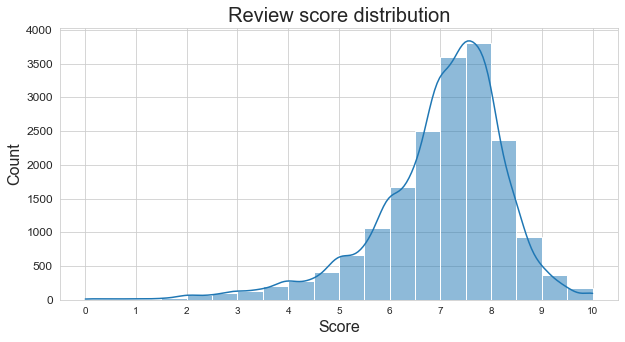

In [8]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 5))
sns.histplot(data=df_reviews_main, x="score", bins=20, kde=True)
plt.xticks(range(0, 11, 1), fontsize=10)
plt.yticks(fontsize=12)
plt.title("Review score distribution", fontsize=20)
plt.xlabel('Score', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.show()


Seems like reviewers tend to most often give scores in the range of 6.5-8.5. Scores below 2 are extremely rare.

This is perhaps counter-inutitive to some people, who may assume that if a perfectly average album deserves a score of 5, then scores should be more-or-less equally distributed around this number.

The reason for this could be the tendency of Pitchfork to mostly review albums of artists, who are already considered good.

<h1 style="color: #2e7de8;background-color: #abb2b9 ;font-family: Lucida Bright, Georgia, serif;font-size:150%;text-align:center">Reviewed albums by genre </h1>

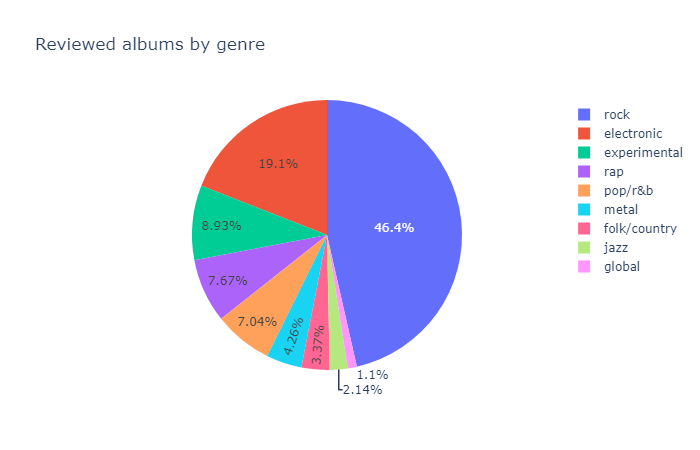

In [17]:
genres_count = df_genres_scores.groupby("genre")["score"].count()

fig = px.pie(genres_count, values='score', names=genres_count.index, title='Reviewed albums by genre')
fig.show("png")

Rock albums reviews are the most common ones on the site, while global albums are the least popular.

<h1 style="color: #b41b57 ;background-color: #abb2b9 ;font-family: Lucida Bright, Georgia, serif;font-size:150%;text-align:center">Average scores by genre </h1>


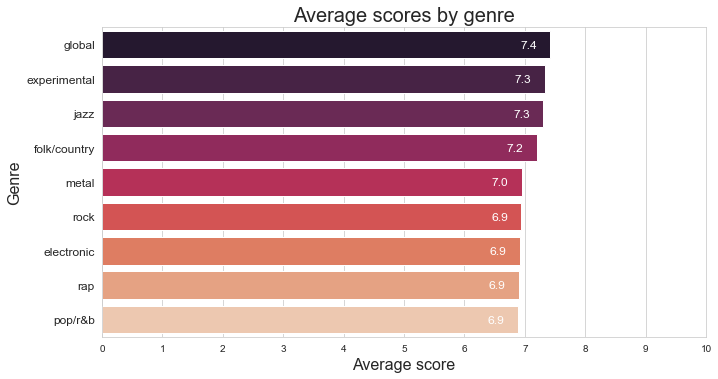

The average score across all genres is 6.99


In [10]:
genres_scores = df_genres_scores.groupby("genre")["score"].mean().sort_values(ascending=False)
sns.set_style("whitegrid")
plt.figure(figsize=(10, 5))
plot = sns.barplot(x=genres_scores, y=genres_scores.index, palette="rocket", dodge=False)
plt.xticks(np.arange(0.0, 11.0, 1.0), fontsize=10)

plt.yticks(fontsize=12)
plt.tight_layout()
plt.title("Average scores by genre", fontsize=20)
plt.xlabel('Average score', fontsize=16)
plt.ylabel('Genre', fontsize=16)
plt.grid(which="minor", linestyle='-', axis="x")

add_val_labels(plot)

plt.show()

print("The average score across all genres is " + str(round(df_genres_scores["score"].mean(),2)))

There is a slight preference for music genres of global, experimental, jazz and folk/country.

<h1 style="color: #b06c99 ;background-color: #abb2b9 ;font-family: Lucida Bright, Georgia, serif;font-size:150%;text-align:center">Top 10 artists by average score </h1>


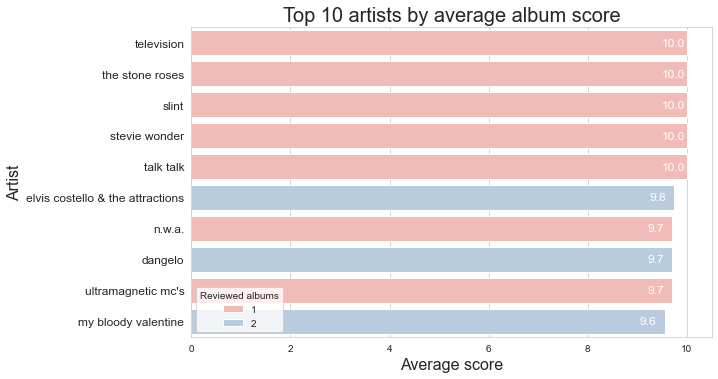

In [11]:
top_10_artists = df_artists_scores.groupby("artist")["score"].agg(["mean", "count"]).sort_values(by="mean", ascending=False).reset_index()[0:10]
sns.set_style("whitegrid")
plt.figure(figsize=(10, 5))
plot = sns.barplot(x=top_10_artists["mean"], y=top_10_artists["artist"], palette="Pastel1", hue=top_10_artists["count"], dodge=False)
plt.xticks(fontsize=10)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.title("Top 10 artists by average album score", fontsize=20)
plt.xlabel('Average score', fontsize=16)
plt.ylabel('Artist', fontsize=16)
plt.grid(which="minor", linestyle='-', axis="x")
plt.legend(title="Reviewed albums", loc="lower left")

add_val_labels(plot)

plt.show()


As we can see from the above chart, only 5 out of 18831 artists have the average review score of 10, but all of them had only one of their albums reviewed.

Additionally, score differences between those top 10 artists are very small (less than 0.5 between the 1st and 10th artist).

Perhaps it's more informative to rank artists based on how many "Best new music" highlights their albums scored.

<h1 style="color: #157e0a ;background-color: #abb2b9 ;font-family: Lucida Bright, Georgia, serif;font-size:150%;text-align:center">Top 10 artists by no. of "Best new music" highlights</h1>


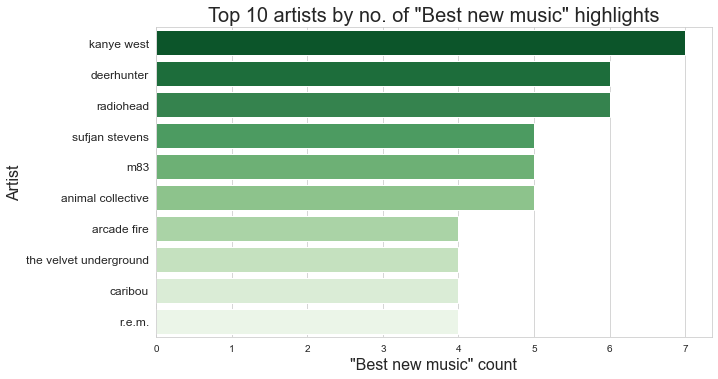

In [12]:
top_10_artists_bnm = df_artists_scores[df_artists_scores["best_new_music"] == True].groupby("artist")["best_new_music"].agg(["count"]).sort_values(by="count", ascending=False).reset_index()[0:10]
sns.set_style("whitegrid")
plt.figure(figsize=(10, 5))
plot = sns.barplot(x=top_10_artists_bnm["count"], y=top_10_artists_bnm["artist"], palette="Greens_r", dodge=False)
plt.xticks(fontsize=10)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.title("Top 10 artists by no. of \"Best new music\" highlights", fontsize=20)
plt.xlabel('\"Best new music\" count', fontsize=16)
plt.ylabel('Artist', fontsize=16)
plt.grid(which="minor", linestyle='-', axis="x")
plt.show()

In this case, Kanye West is the sole leader of the ranking, being the only one with 7 albums featured in the "Best new music" section of the page.

This metric seems more accurate if we want to determine the best artist, because it proves that they consinstently produce great albums.

<h1 style="color: #d00c65 ;background-color: #abb2b9 ;font-family: Lucida Bright, Georgia, serif;font-size:150%;text-align:center">Top 10 labels by no. of "Best new music" highlights</h1>


Next, let's take a look at publishing labels and see which of them have published the most albums featured in the "Best new music section".



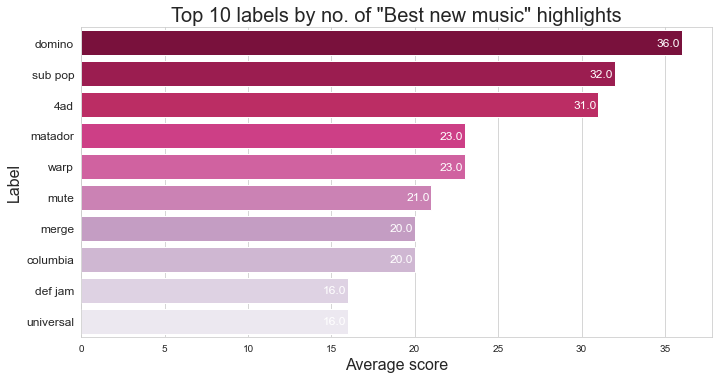

In [13]:
top_10_labels_bnm = df_labels_scores[df_labels_scores["best_new_music"] == True].groupby("label")["best_new_music"].agg(["count"]).sort_values(by="count", ascending=False).reset_index()[0:10]
sns.set_style("whitegrid")
plt.figure(figsize=(10, 5))
plot = sns.barplot(x=top_10_labels_bnm["count"], y=top_10_labels_bnm["label"], palette="PuRd_r", dodge=False)
plt.xticks(fontsize=10)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.title("Top 10 labels by no. of \"Best new music\" highlights", fontsize=20)
plt.xlabel('Average score', fontsize=16)
plt.ylabel('Label', fontsize=16)
plt.grid(which="minor", linestyle='-', axis="x")

add_val_labels(plot, spacing=float(1.5))

plt.show()

Publishing label "Domino" is the clear winner.

<h1 style="color: #bc77d8  ;background-color: #abb2b9 ;font-family: Lucida Bright, Georgia, serif;font-size:150%;text-align:center">Amount of reviews by year</h1>


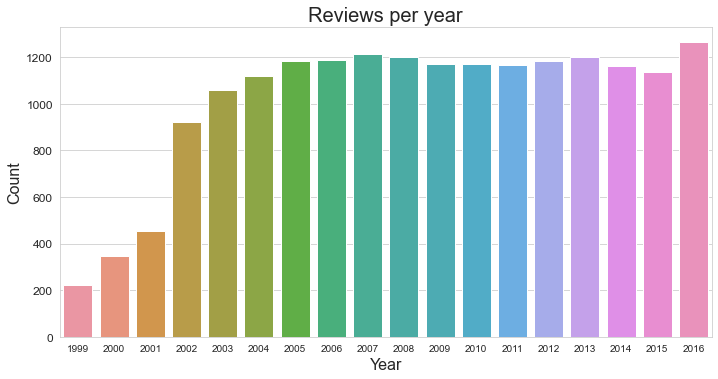

In [14]:
years_reviews = df_reviews_main.groupby("pub_year")["title"].agg(["count"]).sort_values(by="pub_year", ascending=True).reset_index()
years_reviews = years_reviews.drop(index=18)
plt.figure(figsize=(10, 5))
sns.barplot(x=years_reviews["pub_year"], y=years_reviews["count"], dodge=False)
plt.xticks(fontsize=10)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.title("Reviews per year", fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.grid(which="minor", linestyle='-', axis="x")
plt.show()

So far, 2016 has been the most active year for Pitchfork.

Note: We have removed reviews from the year 2017, because data for that year is incomplete and only contains a handful of reviews

Next, we'll consider how many high scoring albums (albums with score of at least 9) were reviewed in each year in relation to the total number of reviewed albums.

<h1 style="color: #dae37f ;background-color: #abb2b9 ;font-family: Lucida Bright, Georgia, serif;font-size:150%;text-align:center">Percentage of highly rated albums per year</h1>

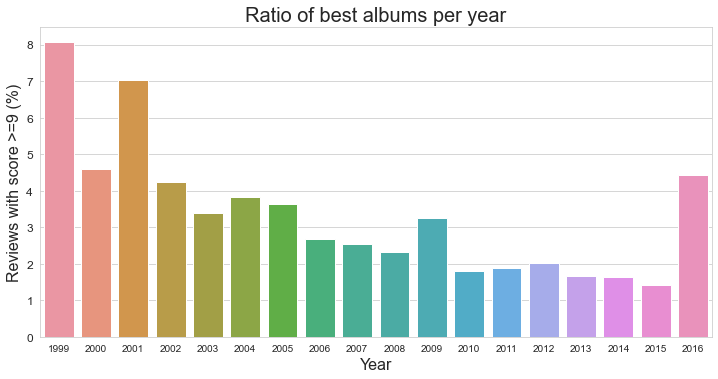

In [15]:
years_reviews["count_best"] = \
df_reviews_main[df_reviews_main["score"] >= 9].groupby("pub_year")["title"].agg(["count"]).sort_values(by="pub_year", ascending=True).reset_index()["count"]
years_reviews["best_percentage"] = years_reviews.apply(lambda x: round((int(x["count_best"]) / int(x["count"])) * 100, 2), axis=1)
sns.set_style("whitegrid")
plt.figure(figsize=(10, 5))
sns.barplot(x=years_reviews["pub_year"], y=years_reviews["best_percentage"], dodge=False)
plt.xticks(fontsize=10)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.title("Ratio of best albums per year", fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Reviews with score >=9 (%)', fontsize=16)
plt.grid(which="minor", linestyle='-', axis="x")
plt.show()


It would seem like the best rated albums have been reviewed in 1999, so we could consider it the best year for music by that metric.

On the other hand, it's worth considering that it was also a year with the lowest amount of reviewed albums, which could indicate that the authors were mostly focusing on writing reviews for the best and most popular albums

<h1 style="color: #f63c3f ;background-color: #abb2b9 ;font-family: Lucida Bright, Georgia, serif;font-size:150%;text-align:center">Wordcloud: "Best new music" reviews</h1>

Which words do reviewers use to describe the best music albums? Let's take a look.

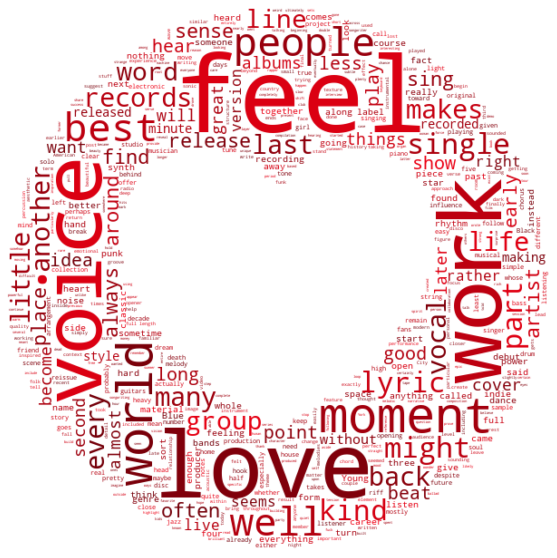

In [16]:
def red_color_func(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
    h = int(360.0 * 252.0 / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)

    return "hsl({}, {}%, {}%)".format(h, s, l)


stopwords = set(STOPWORDS)
stopwords.update(
    ["album", "one", "band", "song", "sound", "music", "songs", "record", "track", "time", "even", "make", "still", "s",
     "rock", "way", "sounds", "pop", "thing", "first", "guitar", "much", "now", "year", "years", "made", "liner",
     "note", "come", "tracks", "know", "something", "title", "take", "shit", "shat", "though", "seem", "never"])

good_text = " ".join(review for review in df_reviews_main[df_reviews_main["best_new_music"] == True]["content"])
mask = np.asarray(Image.open("heart.jpg"))

wordcloud_good = WordCloud(background_color="white", max_words=500, mask=mask, stopwords=stopwords, min_word_length=4,
                           collocation_threshold=12, color_func=red_color_func).generate(good_text)

plt.figure(figsize=[10, 10])
plt.imshow(wordcloud_good, interpolation="bilinear")
plt.axis("off")
plt.show()

<h1 style="color:white;background-color: #e37ff5 ;font-family: Lucida Bright, Georgia, serif;font-size:200%;text-align:center">Conclusions </h1>

### - Reviewers tend to most often give scores in the range of 6.5 - 8.5
### - Rock is the most popular genre
### - Global albums tend to receive slightly better scores while pop/r&b albums slightly worse
### - Kanye West is the most successful artist
### - Domino is the most successful publishing label
### - 2016 has been the most active year for the site